In [ ]:
# !pip install pyspellchecker


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import spacy
import textstat
import numpy as np
import re
from collections import Counter
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [5]:
data = pd.read_csv('UMS_2.csv')
data.head()

,Row,Sample Name,Transaction Id,Anon Student Id,Session Id,Time,Time Zone,Student Response Type,Student Response Subtype,Tutor Response Type,...,CF (AI_Evaluation),CF (AI_Rephrased_Response),CF (AI_Request_Counter),CF (AiEnabled),CF (Condition),CF (Counterbalanced),CF (Sequence),CF (tool_event_time),CF (tutor_event_time),Event Type
0,35,All Data,d2641eb584d67e3a09f5adfbc9c464b9,Stu_003e8f3cf4fd2af060aae025ded87e3b,ctat_session_d87b8a9a-4f7d-3a04-f65a-00e04d849336,8/7/24 21:05,UTC,ATTEMPT,NaN,RESULT,...,NaN,NaN,NaN,NaN,Mixed,"Scenario Kevin, Scenario Carla",NaN,2024-08-07 21:05:43.502 UTC,2024-08-07 21:05:43.503 UTC,NaN
1,39,All Data,e938580cb64f86e929d6bfac9f127187,Stu_003e8f3cf4fd2af060aae025ded87e3b,ctat_session_d87b8a9a-4f7d-3a04-f65a-00e04d849336,8/7/24 21:08,UTC,ATTEMPT,NaN,RESULT,...,NaN,NaN,NaN,NaN,Mixed,"Scenario Kevin, Scenario Carla",NaN,2024-08-07 21:08:16.076 UTC,2024-08-07 21:08:16.077 UTC,NaN
2,52,All Data,ed7aed67cb9cc3b017f311ee650d0c78,Stu_003e8f3cf4fd2af060aae025ded87e3b,ctat_session_d87b8a9a-4f7d-3a04-f65a-00e04d849336,8/7/24 21:16,UTC,ATTEMPT,NaN,RESULT,...,NaN,NaN,NaN,NaN,Mixed,"Scenario Kevin, Scenario Carla",NaN,2024-08-07 21:16:04.021 UTC,2024-08-07 21:16:04.022 UTC,NaN
3,55,All Data,d9c1996b89480729914c12a6b496503a,Stu_003e8f3cf4fd2af060aae025ded87e3b,ctat_session_d87b8a9a-4f7d-3a04-f65a-00e04d849336,8/7/24 21:18,UTC,ATTEMPT,NaN,RESULT,...,NaN,NaN,NaN,NaN,Mixed,"Scenario Kevin, Scenario Carla",NaN,2024-08-07 21:18:07.005 UTC,2024-08-07 21:18:07.006 UTC,NaN
4,327,All Data,1465bba28a4c0c4a66d723a4e8f5b515,Stu_00b5f036f5c4a9d12d0431b66b449927,ctat_session_f4cc9999-fb2c-4753-7b4c-29ae2e3c83b5,4/29/24 11:51,UTC,ATTEMPT,NaN,RESULT,...,NaN,NaN,NaN,NaN,Open-response only,"Scenario Carla, Scenario Kevin",NaN,2024-04-29 11:51:20.514 UTC,2024-04-29 11:51:20.516 UTC,NaN


In [6]:
data.columns

Index(['Row', 'Sample Name', 'Transaction Id', 'Anon Student Id', 'Session Id',
       'Time', 'Time Zone', 'Student Response Type',
       'Student Response Subtype', 'Tutor Response Type',
       'Tutor Response Subtype', 'Level (Lesson)', 'Level (Level2)',
       'Problem Name', 'Problem View', 'Problem Start Time', 'Step Name',
       'Attempt At Step', 'Is Last Attempt', 'Outcome', 'Selection', 'Action',
       'Input', 'Rater 1: Obviously AI-generated Response (yes=1; no= 0)',
       'Rater 2: Obviously AI-generated Response (yes=1; no= 0)',
       'Source of Truth: Obviously AI-generated',
       'Rater 1: Authentic, Real Person Response (yes=1; no=0)',
       'Rater 2: Authentic, Real Person Response (yes=1; no=0)',
       'Source of Truth: Authentic, Real Person', 'Duration (sec)',
       'Feedback Text', 'Feedback Classification', 'Help Level',
       'Total Num Hints', 'KC (Single-KC)', 'KC Category (Single-KC)',
       'KC (Unique-step)', 'KC Category (Unique-step)', 'Schoo

In [7]:
data['Source of Truth: Obviously AI-generated'].value_counts()

Source of Truth: Obviously AI-generated
1.0    899
0.0    506
0.5    230
Name: count, dtype: int64

In [8]:
df = data[['Transaction Id', 'Anon Student Id', 'Input', 'Source of Truth: Obviously AI-generated', 'Duration (sec)']]
df.head()

,Transaction Id,Anon Student Id,Input,Source of Truth: Obviously AI-generated,Duration (sec)
0,d2641eb584d67e3a09f5adfbc9c464b9,Stu_003e8f3cf4fd2af060aae025ded87e3b,One way to motivate students to complete their...,0.0,73.5
1,e938580cb64f86e929d6bfac9f127187,Stu_003e8f3cf4fd2af060aae025ded87e3b,Positive Reinforcement: Explicitly acknowledge...,1.0,36
2,ed7aed67cb9cc3b017f311ee650d0c78,Stu_003e8f3cf4fd2af060aae025ded87e3b,"Carla, have you ever wondered how designers us...",0.5,0
3,d9c1996b89480729914c12a6b496503a,Stu_003e8f3cf4fd2af060aae025ded87e3b,Builds a Collaborative Relationship: Offers su...,1.0,20
4,1465bba28a4c0c4a66d723a4e8f5b515,Stu_00b5f036f5c4a9d12d0431b66b449927,"Carla, think of math as another canvas for you...",1.0,0


In [9]:
df.isnull().sum()
df = df.dropna()

In [10]:
train_df = pd.read_csv("train_data_5.csv")
test_df = pd.read_csv("test_data_5.csv")

train_df.rename(columns={'Input': 'text', 'Source of Truth: Obviously AI-generated': 'label'}, inplace=True)
test_df.rename(columns={'Input': 'text', 'Source of Truth: Obviously AI-generated': 'label'}, inplace=True)

In [11]:
nlp = spacy.load("en_core_web_sm")
spell = SpellChecker()

# sentence length, presence of you, bulleted, numbers, punctuation 
# spelling errors, readability

AI_words = ['additionally', 'overall', 'furthermore', 'moreover', 'in conclusion', 'consequently', 'generate']
human_words = ['I would say', 'I would do', 'I think', 'I believe', 'in my opinion']

def extract_rubric_features(text):
    if not isinstance(text, str) or not text.strip():
        return {
            'is_list': 0, 'text_length': 0, 'avg_sent_length': 0,
            'flesch_grade': 0, 'discourse_marker_count': 0, 'you_count': 0,
            'has_quotes_at_ends': 0, 'misspelling_count': 0, 'hedging_phrase_count': 0,
            'is_incomplete_sent': 0, 'colon_count': 0, 'dash_count': 0
        }

    doc = nlp(text)
    words = [token.text for token in doc if token.is_alpha]
    lower_text = text.lower()

    is_list = 1 if re.search(r'^\s*(?:[\*•-]|\d+[\.\)])', text, re.MULTILINE) else 0

    text_length = len(doc)

    num_sents = len(list(doc.sents))
    avg_sent_length = len(words) / num_sents if num_sents > 0 else 0
    flesch_grade = textstat.flesch_kincaid_grade(text) 

    AI_marker = sum(1 for marker in AI_words if marker in lower_text)

    you_count = lower_text.count('you ') + lower_text.count(' you.')

    has_quotes = 1 if text.startswith('"') and text.endswith('"') else 0

    misspelled_words = spell.unknown(words)
    misspelling_count = len(misspelled_words)

    human_marker = sum(1 for phrase in human_words if phrase in lower_text)

    is_incomplete_sent = 1 if not text.strip().endswith(('.', '!', '?', '"')) else 0
    colon_count = text.count(':')
    hyphen_count = text.count('-')

    features = {
        'is_bulleted': is_list,
        'text_length': text_length,
        'avg_sent_length': avg_sent_length,
        'flesch_grade': flesch_grade,
        'discourse_marker_count': AI_marker,
        'you_count': you_count,
        'has_quotes_at_ends': has_quotes,
        'misspelling_count': misspelling_count,
        'hedging_phrase_count': human_marker,
        'colon_count': colon_count,
        'dash_count': hyphen_count,
        'is_incomplete_sent': is_incomplete_sent
    }
    return features

In [12]:
X_train_features = pd.DataFrame(train_df['text'].apply(extract_rubric_features).tolist())
X_train_features.fillna(0, inplace=True)
y_train = train_df['label']

X_test_features = pd.DataFrame(test_df['text'].apply(extract_rubric_features).tolist())
X_test_features.fillna(0, inplace=True)
y_test = test_df['label']

In [13]:
scaler = StandardScaler()
scaler.fit(X_train_features)
X_train_scaled = scaler.transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

In [14]:
# in y replace 0.5 with 2
y_train = y_train.replace(0.5, 2)
y_test = y_test.replace(0.5, 2)

In [18]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Train accuracy:", model.score(X_train, y_train))
    print("Test accuracy:", model.score(X_test, y_test))
    
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    return model

Train accuracy: 0.9861751152073732
Test accuracy: 0.7597597597597597
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       116
         1.0       0.80      0.89      0.84       166
         2.0       0.40      0.31      0.35        51

    accuracy                           0.76       333
   macro avg       0.67      0.66      0.66       333
weighted avg       0.75      0.76      0.75       333



RandomForestClassifier(random_state=0)

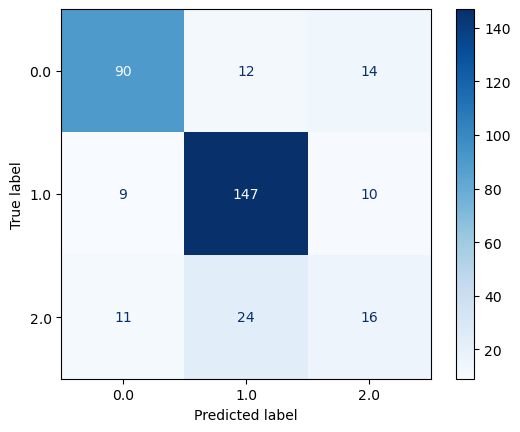

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
train_and_evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test)

Train accuracy: 0.8118279569892473
Test accuracy: 0.7447447447447447
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78       116
         1.0       0.77      0.90      0.83       166
         2.0       0.30      0.06      0.10        51

    accuracy                           0.74       333
   macro avg       0.60      0.59      0.57       333
weighted avg       0.69      0.74      0.70       333



LogisticRegression(max_iter=1000, random_state=0)

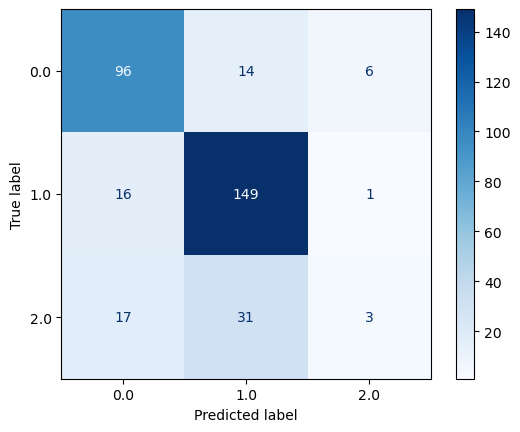

In [20]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000, random_state=0)
train_and_evaluate_model(log_model, X_train_scaled, y_train, X_test_scaled, y_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits

--- Final Evaluation on the Held-Out Test Set ---
Train accuracy: 0.8525345622119815
Test accuracy: 0.7747747747747747

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81       116
         1.0       0.79      0.93      0.86       166
         2.0       0.47      0.18      0.26        51

    accuracy                           0.77       333
   macro avg       0.69      0.64      0.64       333
weighted avg       0.74      0.77      0.75       333



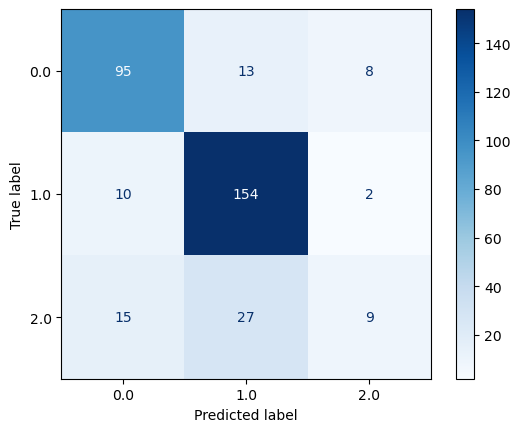

In [ ]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

model = RandomForestClassifier(random_state=0)

param_grid = {'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15],
    'n_estimators': [50, 100, 200, 250]}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

print("Train accuracy:", best_model.score(X_train_scaled, y_train))
print("Test accuracy:", best_model.score(X_test_scaled, y_test))

y_pred = best_model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, cmap='Blues')
plt.show()
